In [21]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt

In [22]:
# Path to the .mhd files
filenameT1 = "./patient_109/mr_T1/patient_109_mr_T1.mhd"
filenameT2 = "./patient_109/mr_T2/patient_109_mr_T2.mhd"

# Slice index to visualize with 'sitk_show'
idxSlice = 20

# int label to assign to the segmented gray matter
labelGrayMatter = 1

In [23]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda     = SimpleITK.GetArrayFromImage(img)
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1]
    extent  = (0, nda.shape[1], nda.shape[0], 0)
    fig     = plt.figure(figsize=figsize, dpi=dpi)
    ax      = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda, extent=extent, interpolation=None)

    if title:
        plt.title(title)

    plt.show()

In [24]:
# ##Options

In [25]:
imgT1Original = SimpleITK.ReadImage(filenameT1)
imgT2Original = SimpleITK.ReadImage(filenameT2)

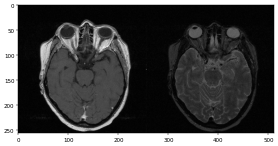

In [26]:
sitk_show(SimpleITK.Tile(imgT1Original[:, :, idxSlice],
                         imgT2Original[:, :, idxSlice],
                         (2, 1, 0)))

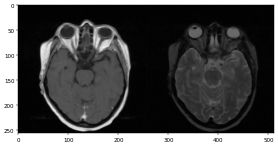

In [27]:
imgT1Smooth = SimpleITK.CurvatureFlow(image1= imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgT2Smooth = SimpleITK.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

sitk_show(SimpleITK.Tile(imgT1Smooth[:, :, idxSlice],
                         imgT2Smooth[:, :, idxSlice],
                         (2, 1, 0)))           

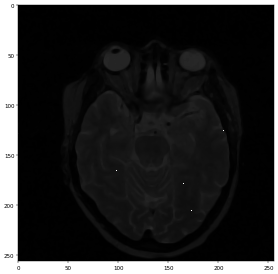

In [32]:
lstSeeds = [(165, 178, idxSlice),
            (98, 165, idxSlice),
            (205, 125, idxSlice),
            (173, 205, idxSlice)]

imgSeeds    = SimpleITK.Image(imgT2Smooth)
for s in lstSeeds:
    imgSeeds[s] = 10000 

sitk_show(imgSeeds[:, :, idxSlice])

In [38]:
def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(SimpleITK.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(SimpleITK.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    sitk_show(SimpleITK.Compose(lstImgToCompose))

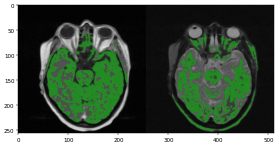

In [40]:
imgGrayMatterT1 = SimpleITK.ConfidenceConnected(image1              = imgT1Smooth,
                                                seedList            = lstSeeds,
                                                numberOfIterations  = 7,
                                                multiplier          = 1.0,
                                                replaceValue        = labelGrayMatter)

imgGrayMatterT2 = SimpleITK.ConfidenceConnected(image1              = imgT2Smooth,
                                                seedList            = lstSeeds,
                                                numberOfIterations  = 7,
                                                multiplier          = 1.5,
                                                replaceValue        = labelGrayMatter)

imgT1SmoothInt  = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1Smooth),
                                 imgGrayMatterT1.GetPixelID())
imgT2SmoothInt  = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT2Smooth),
                                 imgGrayMatterT2.GetPixelID())

sitk_tile_vec([SimpleITK.LabelOverlay(imgT1SmoothInt[:, :, idxSlice],
                                      imgGrayMatterT1[:, :, idxSlice]),
               SimpleITK.LabelOverlay(imgT2SmoothInt[:, :, idxSlice],
                                      imgGrayMatterT2[:, :, idxSlice])])

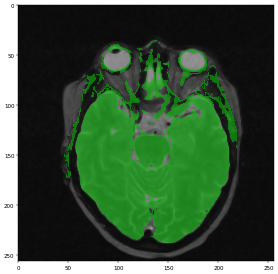

In [41]:
imgComp = SimpleITK.Compose(imgT1Smooth, imgT2Smooth)

imgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp,
                                                        seedList=lstSeeds,
                                                        multiplier=0.1,
                                                        replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice],
                                 imgGrayMatterComp[:,:,idxSlice]))

In [ ]:
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatter.mhd")